In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [12]:
image = cv2.imread("sfinge.bmp") 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

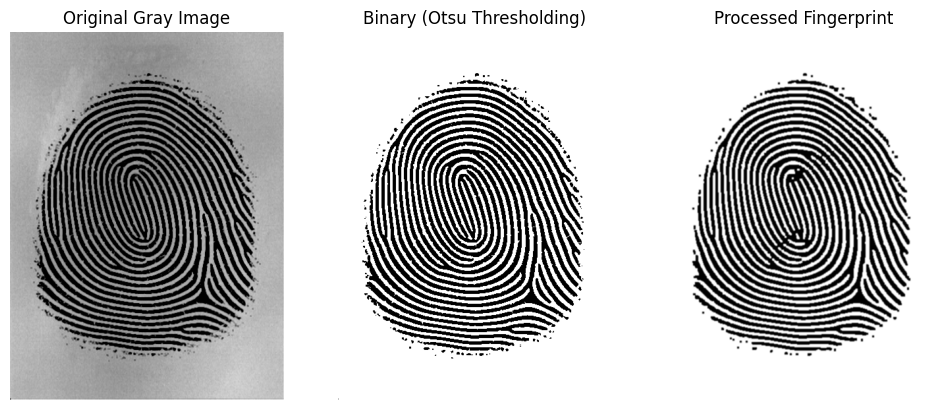

In [13]:
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Structural Element for Morphological Operations
kernel = np.ones((3, 3), np.uint8)

# Erosion (Reduces noise)
eroded = cv2.erode(binary, kernel, iterations=1)

# Expansion (Refines lines)
dilated = cv2.dilate(eroded, kernel, iterations=1)

# Clears isolated noises
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# Fills in gaps
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

# Noise Reduction - Gaussian Blur
denoised = cv2.GaussianBlur(closed, (3, 3), 0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.title("Original Gray Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binary (Otsu Thresholding)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised, cmap='gray')
plt.title("Processed Fingerprint")
plt.axis('off')

plt.show()

In [14]:
image = cv2.imread("sfinge.bmp", cv2.IMREAD_GRAYSCALE)  
_, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


def skeletonize(image):
    skeleton = np.zeros_like(image) 
    temp = np.zeros_like(image)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    
    while True:
        eroded = cv2.erode(image, kernel)  
        opened = cv2.dilate(eroded, kernel) 
        temp = cv2.subtract(image, opened)  
        skeleton = cv2.bitwise_or(skeleton, temp)  
        image = eroded.copy() 

        if cv2.countNonZero(image) == 0: 
            break
    
    return skeleton


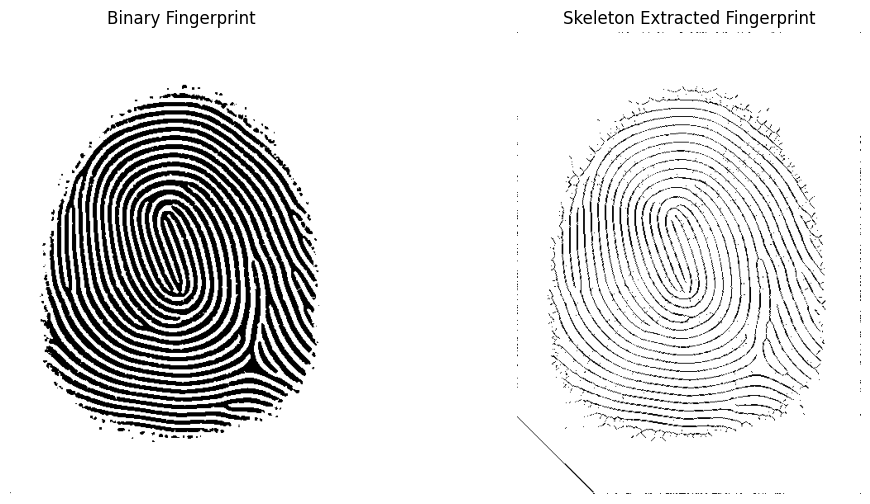

In [15]:
skeleton = skeletonize(binary)
skeleton = cv2.bitwise_not(skeleton) 

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(binary, cmap='gray')
plt.title("Binary Fingerprint")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(skeleton, cmap='gray')
plt.title("Skeleton Extracted Fingerprint")
plt.axis('off')

plt.show()